# ML Course 2024 |  Medical Expenses Prediction Challenge

This notebook should serve as a starting point to work on the project. Please read the project description first.

In [1]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2 

# Set team ID
Important: set your Team ID here. You can find it in CMS.

In [2]:
team_id = "18"  # put your team id here

# [Colab only] Connect to your Google Drive

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# %cd "/content/drive/MyDrive/path/to/your/project"

# Imports

[Colab only] Note: if you need to install any packages, run a code cell with content `!pip install packagename`

In [5]:
import os
from itertools import product
from typing import Any

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as skm
from lightgbm import LGBMRegressor
from prettytable import PrettyTable
from scipy import stats
from scipy.stats import norm, skew  # for some statistics
from sklearn import linear_model, preprocessing
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    SelectKBest,
    VarianceThreshold,
    chi2,
    f_regression,
    mutual_info_regression,
)
from sklearn.linear_model import (
    GammaRegressor,
    Lasso,
    LassoCV,
    LassoLars,
    LassoLarsCV,
    LinearRegression,
    LogisticRegression,
    PassiveAggressiveRegressor,
    PoissonRegressor,
    Ridge,
    RidgeCV,
    TweedieRegressor,
)
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    Normalizer,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    quantile_transform,
)
from skopt.space import Categorical, Integer, Real

from utils import helpers
from utils import metrics as my_metrics
from utils import plots
from utils import statistical as st
from utils.config import CUML_INSTALLED, DPI, PAPER_STYLE
from utils.param_grids import choose_param_grid

# Use cuML to use GPU-accelerated models
USE_CUML = True

if CUML_INSTALLED and USE_CUML:
    from cuml.common.device_selection import get_global_device_type, set_global_device_type
    from cuml.kernel_ridge import KernelRidge
    from cuml.linear_model import Lasso, LinearRegression, Ridge
    from cuml.svm import SVR

    set_global_device_type("gpu")

    print("cuML's default execution device:", get_global_device_type())
else:
    from sklearn.kernel_ridge import KernelRidge
    from sklearn.svm import SVR

# Constants that define the classification and regression targets
CLF_TARGET = "UTILIZATION"
REG_TARGET = "TOT_MED_EXP"

cuML's default execution device: DeviceType.device


# **Data Analysis & Preprocessing**

## Load Data

In a first step, we load the provided training data from the csv file

In [6]:
df_train = pd.read_csv("data/train.csv")
df_train.drop(columns=[CLF_TARGET], inplace=True) # drop the classification target
df_train_mirror = df_train.copy()

print("The loaded dataset has {} rows and {} columns".format(df_train.shape[0], df_train.shape[1]))

The loaded dataset has 15000 rows and 109 columns


In [7]:
df_train.head()

,RACE,SEX,PANEL,WEIGHT,STUDENT_STAT,MIL_ACTIV_DUTY,HON_DISCHARGE,HEALTH_STAT,MENTAL_HLTH,CHRON_BRONCH,...,ADHD_DIAG,NUM_PRESCR_MEDS,DIFFIC_HEAR,DIFFIC_SEE,SMOK,OVR_FEEL_14,MENTAL_HLTH_SCR,PHY_HLTH_SCR,OVR_FEEL_30,TOT_MED_EXP
0,Non-White,1,19,7205.036720,-1,2,2,2,2,2,...,-1,0,2,2,2,1,43.82,61.41,3,0
1,White,1,20,5501.113581,-1,4,2,1,1,2,...,-1,12,2,2,2,0,60.12,54.80,0,240
2,White,1,20,16797.708379,-1,4,1,3,1,2,...,-1,20,2,2,2,0,60.35,30.08,0,791
3,Non-White,2,19,3605.218411,-1,2,2,3,3,2,...,-1,20,2,2,2,0,58.32,50.22,0,272
4,Non-White,1,19,11223.127404,1,2,2,1,2,2,...,2,3,2,2,2,0,62.39,56.71,0,1264


## Data exploration

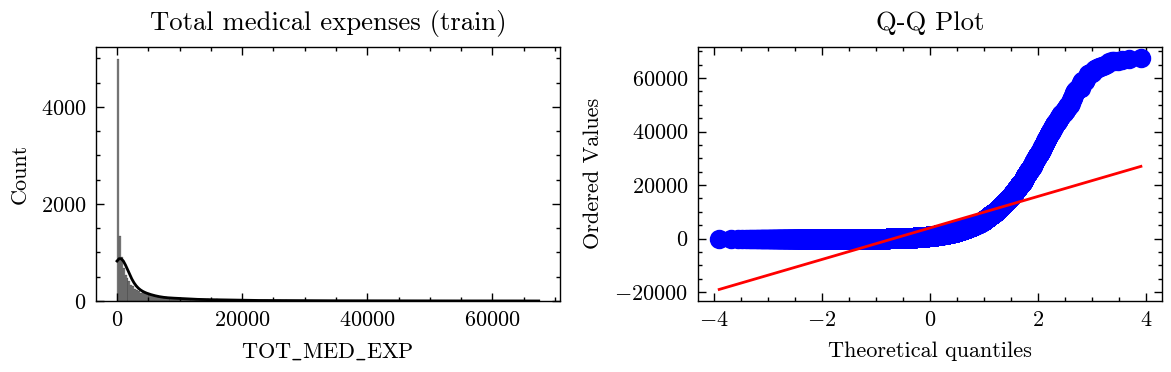

In [57]:
st.plot_distribution_fits(
    df_train,
    REG_TARGET,
    distribution=None,
    style=PAPER_STYLE,
    stat="count",
    titles=["Total medical expenses (train)"],
)

In [9]:
df_train.describe()

,SEX,PANEL,WEIGHT,STUDENT_STAT,MIL_ACTIV_DUTY,HON_DISCHARGE,HEALTH_STAT,MENTAL_HLTH,CHRON_BRONCH,JNT_PAIN,...,ADHD_DIAG,NUM_PRESCR_MEDS,DIFFIC_HEAR,DIFFIC_SEE,SMOK,OVR_FEEL_14,MENTAL_HLTH_SCR,PHY_HLTH_SCR,OVR_FEEL_30,TOT_MED_EXP
count,15000.000000,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.532667,19.53280,9670.900479,-0.658867,2.479533,1.893267,2.378400,2.102067,1.960267,1.636667,...,-0.922400,12.024333,1.924800,1.939067,1.244467,0.235533,43.401995,41.278002,2.054600,4931.666933
std,0.498948,0.49894,8555.466893,1.021778,0.867428,0.741830,1.112038,1.064640,0.468369,0.737942,...,0.482763,22.539929,0.384822,0.360226,1.723127,1.807173,21.392243,20.943971,4.527846,12802.592340
min,1.000000,19.00000,0.000000,-9.000000,-9.000000,-9.000000,-8.000000,-8.000000,-8.000000,-8.000000,...,-9.000000,0.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,0.000000
25%,1.000000,19.00000,3956.827352,-1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,...,-1.000000,0.000000,2.000000,2.000000,1.000000,0.000000,38.877500,33.510000,0.000000,104.000000
50%,2.000000,20.00000,7304.928346,-1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,-1.000000,2.000000,2.000000,2.000000,2.000000,0.000000,51.830000,51.240000,1.000000,911.000000
75%,2.000000,20.00000,12745.004822,-1.000000,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,...,-1.000000,14.000000,2.000000,2.000000,2.000000,0.000000,57.492500,56.150000,3.000000,4015.500000
max,2.000000,20.00000,96471.920237,3.000000,4.000000,4.000000,5.000000,5.000000,2.000000,2.000000,...,2.000000,257.000000,2.000000,2.000000,2.000000,6.000000,75.510000,72.070000,24.000000,236449.000000


In [10]:
# Handling missing values
total_missing_values = df_train.isnull().sum().sum()
print(f"Total number of missing values: {total_missing_values}")

Total number of missing values: 0


In [11]:
categorical_cols, numerical_cols = helpers.categorical_and_numerical_columns(
    df_train.drop(columns=[REG_TARGET])
)

# One-Hot encoding for categorical columns
categorical_encoder, df_train = helpers.handle_categorical_cols(
    df_train, categorical_cols, return_only_encoded=False
)
df_train_mirror = df_train.copy()

print(f"Numerical ({len(numerical_cols)}) ", numerical_cols)
print(f"Categorical ({len(categorical_cols)}): ", categorical_cols)
print(f"Number of columns after one-hot encoding: {df_train_mirror.shape[1]}")

2024-08-10 12:00:35,139 - root - WARNING - Likely categorical columns detected: ['SEX', 'PANEL', 'STUDENT_STAT', 'MIL_ACTIV_DUTY', 'HON_DISCHARGE', 'HEALTH_STAT', 'MENTAL_HLTH', 'CHRON_BRONCH', 'JNT_PAIN', 'PREGNT', 'WALK_LIM', 'ACTIV_LIM', 'SOCIAL_LIM', 'COGNTV_LIM', 'EMPLYMT', 'REGION', 'MARITAL_STAT', 'AGE', 'POVRTY_CAT', 'INSUR_COV', 'MULT_HIGHBP', 'HOUSEWRK_LIM', 'SCHOOL_LIM', 'ADV_NO_FAT_FOOD', 'ADV_EXERCISE_MORE', 'ADV_DNTL_CKP', 'FREQ_DNTL_CKP', 'RSN_NO_DNTL_CKP', 'RSN_NO_MED_CKP', 'EMPLYR_INS', 'DOC_CK_BP', 'TAKE_RISK', 'NUM_DEP_OUT_REP_UNT', 'ADV_BOOST_SEAT', 'WHEN_ADV_BOOST_SEAT', 'FEEL_DEPRS', 'ADV_NO_SMKG', 'AGE_DIAG_ADHD', 'PROB_WKIDS', 'PROB_WBHV', 'WEAR_SEATBLT', 'PUB_ASST', 'EDU_DEG', 'SPOUSE_PRSNT', 'TAX_FORM_TYP', 'FOOD_STMP_MNTHS', 'WHEN_ADV_LAP_BLT', 'EDU_YRS', 'WHEN_LST_ASTHMA', 'DELAY_PRESCR_MED', 'ADV_LAP_BLT', 'ADV_EAT_HLTHY', 'DOC_TIM_ALN', 'APPT_REG_MEDCARE', 'LOST_ALL_TEETH', 'PROB_BILL_PAY', 'ASPRN_REG', 'OCCUP', 'DIFF_ERRND_ALN', 'DIAB_KIDNY', 'DIAB_INSLN'

### *Variance Threshold Analysis*

In [12]:
VARIANCE_THRESHOLD = 0.01  # Drop (quasi-constant) columns with variance < 0.01

# Don't include the target variable in the variance thresholding obviously
df_train_without_reg_target = df_train_mirror.drop(columns=[REG_TARGET])

var_thresh = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
var_thresh.fit(df_train_without_reg_target)
low_variance_cols = df_train_without_reg_target.columns[~var_thresh.get_support()].tolist()
print(f"Columns with var < {VARIANCE_THRESHOLD} ({len(low_variance_cols)}): ", low_variance_cols)

df_train.drop(columns=low_variance_cols, inplace=True)
df_train_mirror.drop(columns=low_variance_cols, inplace=True)
print(f"Number of columns after dropping low variance columns: {df_train_mirror.shape[1]}")

Columns with var < 0.01 (439):  ['ADV_BOOST_SEAT_1', 'HEAR_AID_-7', 'HEAR_AID_-1', 'WEAR_SEATBLT_-7', 'WEAR_SEATBLT_4', 'WEAR_SEATBLT_5', 'WEAR_SEATBLT_6', 'MARITAL_STAT_7', 'MARITAL_STAT_8', 'MARITAL_STAT_9', 'MARITAL_STAT_10', 'DELAY_PRESCR_MED_-8', 'DELAY_PRESCR_MED_-7', 'DELAY_PRESCR_MED_-1', 'WHEN_LST_ASTHMA_-8', 'WHEN_LST_ASTHMA_1', 'WHEN_LST_ASTHMA_2', 'WHEN_LST_ASTHMA_3', 'WHEN_LST_ASTHMA_4', 'WHEN_LST_ASTHMA_5', 'ADV_DNTL_CKP_-8', 'ADV_DNTL_CKP_-7', 'ADV_DNTL_CKP_-1', 'ADV_DNTL_CKP_1', 'ADV_DNTL_CKP_2', 'PUB_ASST_157', 'PUB_ASST_352', 'PUB_ASST_470', 'PUB_ASST_503', 'PUB_ASST_513', 'PUB_ASST_559', 'PUB_ASST_569', 'PUB_ASST_573', 'PUB_ASST_582', 'PUB_ASST_601', 'PUB_ASST_663', 'PUB_ASST_684', 'PUB_ASST_714', 'PUB_ASST_775', 'PUB_ASST_816', 'PUB_ASST_835', 'PUB_ASST_890', 'PUB_ASST_933', 'PUB_ASST_951', 'PUB_ASST_956', 'PUB_ASST_1024', 'PUB_ASST_1097', 'PUB_ASST_1134', 'PUB_ASST_1161', 'PUB_ASST_1171', 'PUB_ASST_1176', 'PUB_ASST_1185', 'PUB_ASST_1249', 'PUB_ASST_1265', 'PUB_ASST

### *Skewness Analysis*

In [13]:
# Skewed features
skewed_feats = (
    df_train[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
)
print("\nSkew in numerical columns: \n")
skewed_numerical_cols = pd.DataFrame({"Skew": skewed_feats})
print(skewed_numerical_cols.head(10))

skewed_numerical_cols = skewed_numerical_cols[abs(skewed_numerical_cols) > 0.75]
print("\nThere are {} skewed numerical columns".format(skewed_numerical_cols.shape[0]))

skewed_numerical_cols = skewed_numerical_cols.index.tolist()


Skew in numerical columns: 

                      Skew
CHILD_SUPP       13.979793
FOOD_STMP_VAL     7.813558
NUM_PRESCR_MEDS   3.452909
TOT_INCOME        2.564671
WEIGHT            2.445741
BM_IDX            2.221857
POVRTY_LEV        2.179222
FAM_INCOME        2.082456
PHY_HLTH_SCR     -1.206700
MENTAL_HLTH_SCR  -1.296197

There are 10 skewed numerical columns


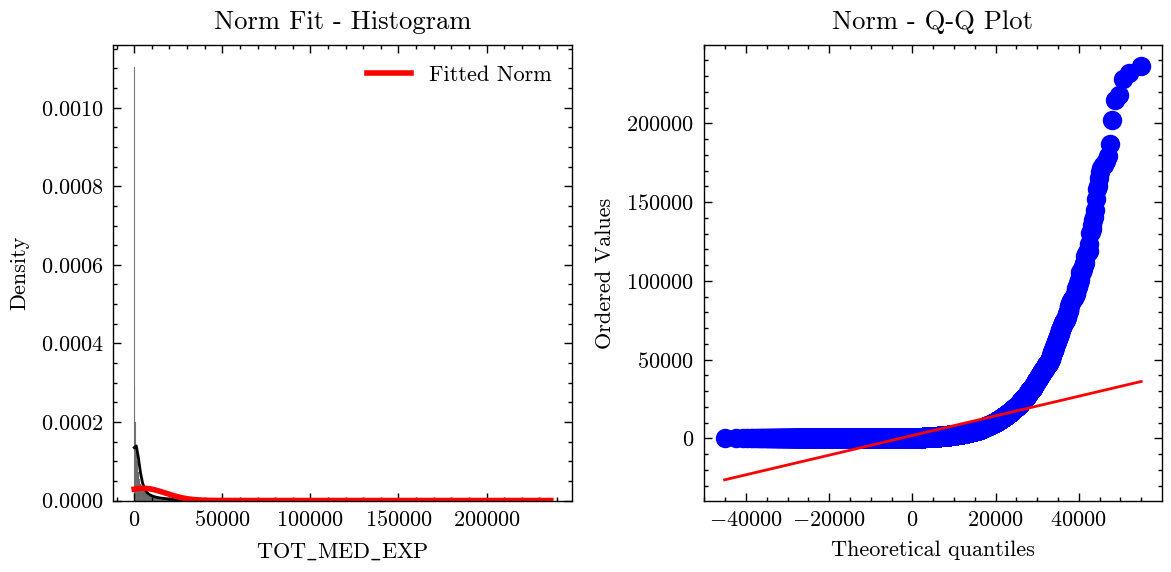

In [14]:
st.plot_distribution_fits(
    df_train, REG_TARGET, distribution="norm", style=PAPER_STYLE, figsize=(6, 3)
)

### *Correlation Analysis*


Found 52 cols with correlation >= 0.9
['POVRTY_LEV', 'ASPRN_REG_2', 'PROB_BILL_PAY_2', 'HIGHCHOL_DIAG_2', 'HON_DISCHARGE_2', 'CHRON_BRONCH_2', 'APPT_REG_MEDCARE_-1', 'PREGNT_2', 'ACTIV_LIM_1', 'ACTIV_LIM_2', 'ADV_NO_FAT_FOOD_2', 'CANCER_DIAG_2', 'COR_HRT_DIAG_2', 'EDU_YRS_-1', 'EDU_YRS_16', 'SMOK_-1', 'DIAB_DIAG_2', 'HOUSEWRK_LIM_-1', 'OVR_FEEL_14_-1', 'HIGH_BP_DIAG_2', 'ADHD_DIAG_2', 'ASTHM_DIAG_2', 'FEEL_DEPRS_-1', 'LOST_ALL_TEETH_2', 'COGNTV_LIM_2', 'DIAB_INSLN_-1', 'DIFFIC_HEAR_1', 'DIFFIC_HEAR_2', 'JNT_PAIN_2', 'EMPHYM_DIAG_2', 'HRT_ATT_DIAG_2', 'TAKE_RISK_-1', 'ANGINA_DIAG_2', 'STROKE_DIAG_2', 'OVR_FEEL_30_-1', 'WALK_LIM_2', 'SOCIAL_LIM_2', 'PANEL_20', 'MIL_ACTIV_DUTY_4', 'DIAB_KIDNY_-1', 'DIAB_KIDNY_2', 'DIFFIC_SEE_1', 'OTH_HRT_DIAG_2', 'MULT_HIGHBP_-1', 'DIFF_ERRND_ALN_2', 'EMPLYR_INS_-1', 'ADV_NO_SMKG_-1', 'ARTHR_DIAG_1', 'ARTHR_DIAG_2', 'EMPLYMT_1', 'EMPLYMT_4', 'ADV_EXERCISE_MORE_2']


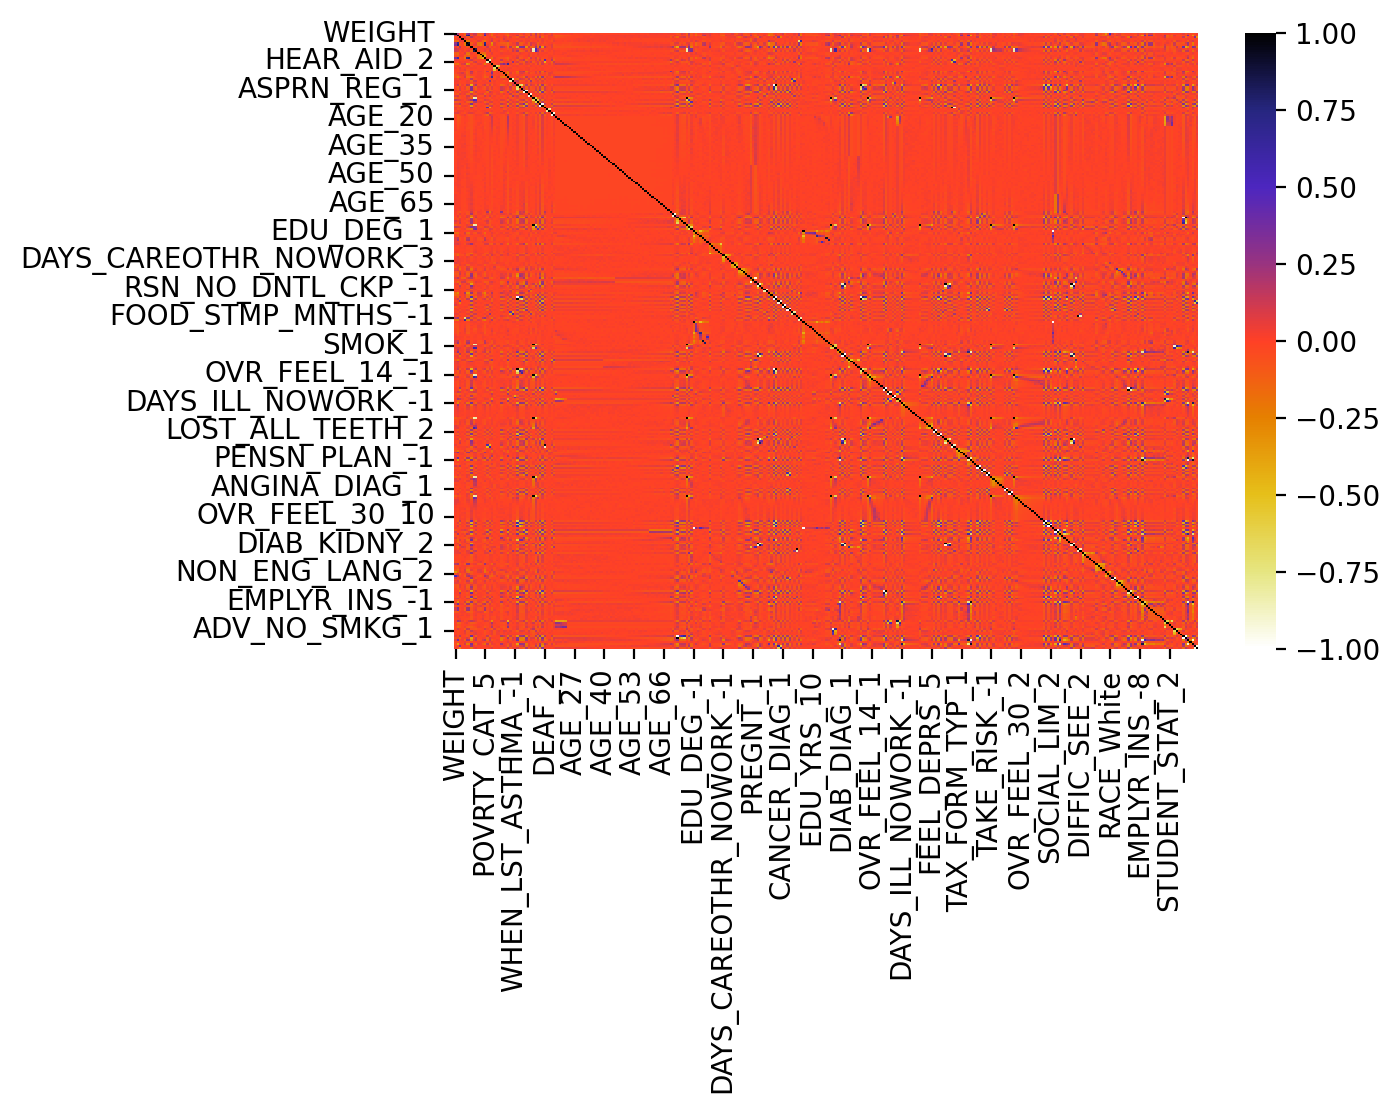

+---------------------------------------------------------------------------+
|                            Correlation Summary                            |
+---------------------+---------------------+---------------------+---------+
|  Correlated Column  |   Correlated With   |     Correlation     | p-value |
+---------------------+---------------------+---------------------+---------+
|      POVRTY_LEV     |      FAM_INCOME     |  0.908062670542643  |   0.0   |
|     ACTIV_LIM_1     |    SCHOOL_LIM_-1    | -0.9844012974035811 |   0.0   |
|     ACTIV_LIM_2     |    SCHOOL_LIM_-1    |         1.0         |   0.0   |
|   HOUSEWRK_LIM_-1   |    SCHOOL_LIM_-1    |         1.0         |   0.0   |
|     ASPRN_REG_2     |     ASPRN_REG_1     | -0.9633333342745349 |   0.0   |
|   PROB_BILL_PAY_2   |   PROB_BILL_PAY_1   | -0.9527370605040555 |   0.0   |
| APPT_REG_MEDCARE_-1 |     DOC_CK_BP_-1    |         1.0         |   0.0   |
|       SMOK_-1       |     DOC_CK_BP_-1    |         1.0       

In [15]:
# Get the correlation matrix of the data (excluding the regression and classification targets!)
# Find the columns that are highly correlated with each other and remove them
CORRELATION_THRESHOLD = 0.9  # 90% correlation threshold

df_train_without_reg_target = df_train_mirror.drop(columns=[REG_TARGET])
correlated_cols, corr, summary = st.correlated_columns(
    df_train_without_reg_target, threshold=CORRELATION_THRESHOLD
)

print(f"\nFound {len(correlated_cols)} cols with correlation >= {CORRELATION_THRESHOLD}")
print(correlated_cols)

plt.figure(figsize=(6, 4))
sns.heatmap(corr, cmap=plt.cm.CMRmap_r)
plt.show()

summary_table = helpers.make_pretty_table(
    summary,
    ["Correlated Column", "Correlated With", "Correlation", "p-value"],
    title="Correlation Summary",
)
print(summary_table)

df_train.drop(columns=correlated_cols, inplace=True)
df_train_mirror.drop(columns=correlated_cols, inplace=True)
print(f"Number of columns after dropping correlated columns: {df_train_mirror.shape[1]}")

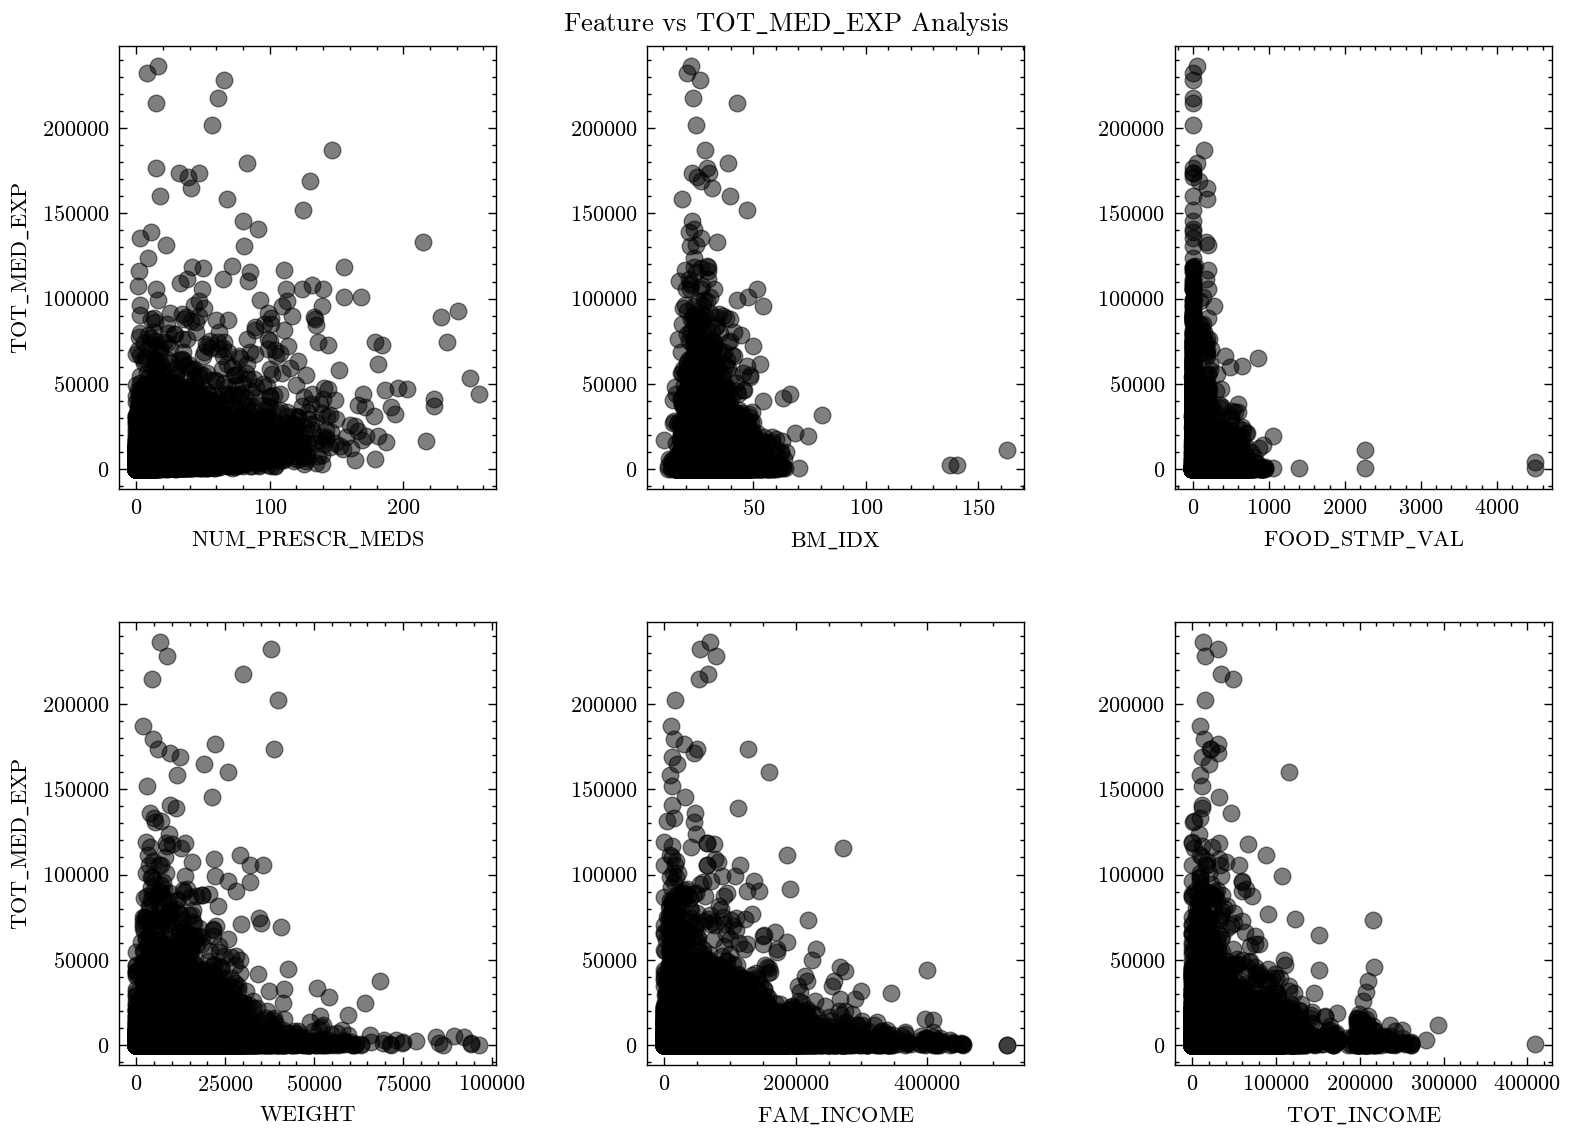

In [16]:
plots.plot_features_vs_target(
    df_train_mirror, REG_TARGET, style=PAPER_STYLE, n_features=6, max_rows=2
)

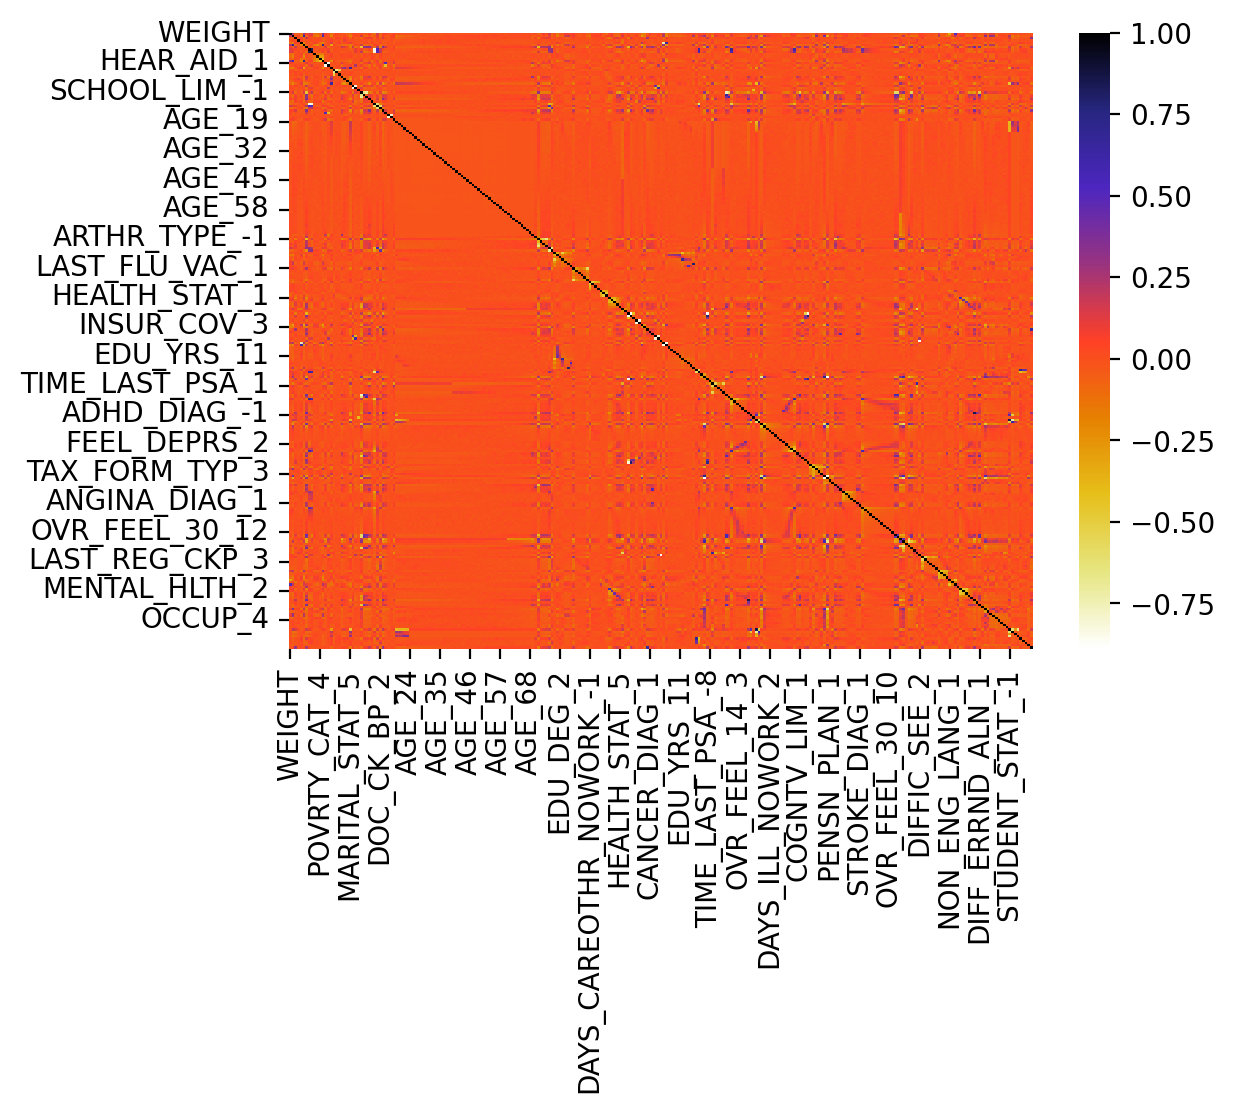

In [17]:
# After Feature Selection
df_train_without_reg_target = df_train_mirror.drop(columns=[REG_TARGET])
_, new_corr, _ = st.correlated_columns(
    df_train_without_reg_target, threshold=CORRELATION_THRESHOLD
)

plt.figure(figsize=(6, 4))
sns.heatmap(new_corr, cmap=plt.cm.CMRmap_r)
plt.show()

### *Outlier Detection*

In [18]:
# outliers = df_train.outliers(method="modified-z-score", z_score_threshold=6.5, z_score_constant=0.6745)
outliers = st.detect_outliers(df_train_mirror, method="iqr", iqr_lower_percentile=1, iqr_upper_percentile=99)
# outliers = df_train.outliers(method="isolation-forest")
print(f"Found {outliers.sum()} outliers of {df_train.shape[0]} samples")

# Drop the outliers
df_train = df_train[~outliers]
df_train_mirror = df_train_mirror[~outliers]
print(f"Number of samples after dropping outliers: {df_train_mirror.shape[0]}")

Found 670 outliers of 15000 samples
Number of samples after dropping outliers: 14330


In [19]:
# Split into features and target for regression and classification
X = df_train.drop(columns=[REG_TARGET])
y_regression = df_train[REG_TARGET]

# **Linear regression**

In this part, we will solve an linear regression task to predict our target `TOT_MED_EXP`, i.e. total medical expences, using the other features.


In its simplest form, predictions of a linear regression model can be summarized as

$$
\hat{y} = \mathbf{w}^T \mathbf{x} = f(\mathbf{x},\mathbf{w})
$$

which can be optimized using the cost function

$$
\mathbf{w}^{*}=\underset{\mathbf{w}}{\arg \min } \frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-f\left(\mathbf{x}_{i}, \mathbf{w}\right)\right)^{2}
$$

### Process the data

In [20]:
print("The dataset now has {} rows and {} columns".format(X.shape[0], X.shape[1]))

# Split X and y for training and validation purposes
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

# If X_train_reg is not a DataFrame, convert it
if not isinstance(X_train_reg, pd.DataFrame):
    X_train_reg = pd.DataFrame(X_train_reg.toarray(), columns=X.columns)
    X_test_reg = pd.DataFrame(X_test_reg.toarray(), columns=X.columns)

print("X_train_reg type:", type(X_train_reg))
print("X_train_reg shape:", X_train_reg.shape)
print("X_test_reg shape:", X_test_reg.shape)

The dataset now has 14330 rows and 273 columns
X_train_reg type: <class 'pandas.core.frame.DataFrame'>
X_train_reg shape: (11464, 273)
X_test_reg shape: (2866, 273)


### Train a linear regression model

In [21]:
# Filter out the columns that were dropped during preprocessing
numerical_cols = helpers.remove_non_existent_columns(numerical_cols, X.columns)
skewed_numerical_cols = helpers.remove_non_existent_columns(skewed_numerical_cols, X.columns)

numerical_indices = helpers.get_column_indices(X, numerical_cols)
skewed_numerical_indices = helpers.get_column_indices(X, skewed_numerical_cols)

In [22]:
pipeline = Pipeline(
    steps=[
        (
            "preprocessor",
            ColumnTransformer(
                transformers=[
                    ("num_power", PowerTransformer(method="yeo-johnson"), skewed_numerical_cols),
                ],
                remainder="passthrough",
            ),
        ),
        (
            "numerical_scaler",
            ColumnTransformer(
                transformers=[("scaler", RobustScaler(), numerical_indices)],
                remainder="passthrough",
            ),
        ),
        # ("poly", PolynomialFeatures(degree=2)),
        ("select", SelectKBest(score_func=f_regression)),
        ("regression", LassoLars()),
    ]
)

param_grid = choose_param_grid(
    pipeline.named_steps["regression"], "grid", add_str_to_keys="regression"
)

# Add the number of features to select to the hyperparameter grid
param_grid["select__k"] = [10, 40, 80]  # Number of top features to select for regression

print(f"Using the following hyperparameter grid for {pipeline.named_steps['regression']}:")
for key, value in param_grid.items():
    print(f"\t{key}: {value}")

print()

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    refit="neg_root_mean_squared_error",
    scoring={
        "neg_root_mean_squared_error": "neg_root_mean_squared_error",
        "neg_median_absolute_error": "neg_median_absolute_error",
        "neg_mean_absolute_error": "neg_mean_absolute_error",
    },
    n_jobs=-2,
    verbose=1,
)

grid_search.fit(X_train_reg, y_train_reg)

best_estimator = grid_search.best_estimator_

print("Best hyperparameters found: ", grid_search.best_params_)

# This won't work if using PCA or Polynomial features before SelectKBest
# print(
#     "Selected features for linear regression:",
#     X.columns[grid_search.best_estimator_.named_steps["select"].get_support(indices=True)],
# )

Using the following hyperparameter grid for LassoLars():
	regression__alpha: [0.0005, 0.1, 1.0, 10.0]
	regression__fit_intercept: [True, False]
	select__k: [10, 40, 80]

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/camilo/Repositorios/venvs/venv_rapids_24.06/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 89 iterations, alpha=3.481e-01, previous alpha=3.481e-01, with an active set of 78 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/venv_rapids_24.06/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 57 iterations, alpha=2.612e+01, previous alpha=2.464e+01, with an active set of 48 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/venv_rapids_24.06/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 94

Best hyperparameters found:  {'regression__alpha': 10.0, 'regression__fit_intercept': True, 'select__k': 80}


### Train a model with a `y` transformed

See: https://scikit-learn.org/dev/auto_examples/compose/plot_transformed_target.html

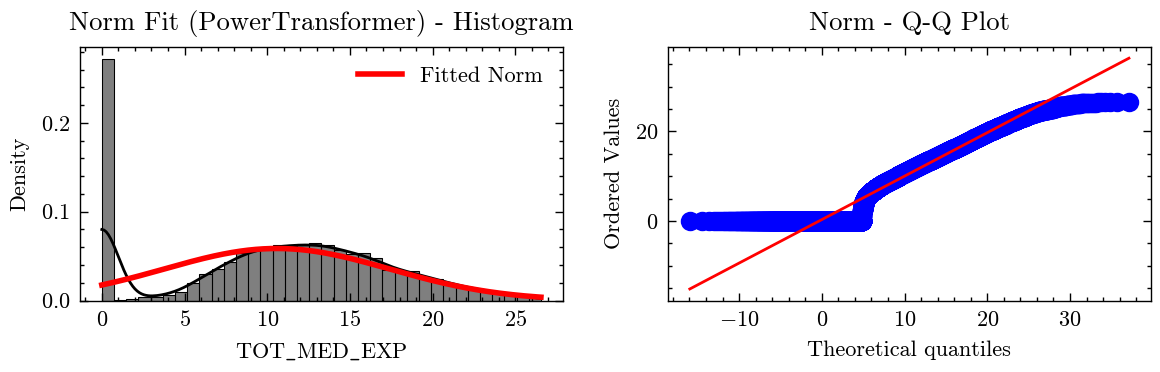

In [44]:
# y_trans = quantile_transform(
#     y_regression.to_frame(), n_quantiles=900, output_distribution="normal", copy=True
# ).squeeze()

st.plot_distribution_fits(
    df_train,
    REG_TARGET,
    apply_transform=PowerTransformer(method="yeo-johnson", standardize=False),
    show_original_histogram=True,
    style=PAPER_STYLE
)

In [24]:
# Modify pipeline for target transformation
pipeline_y_transformed = Pipeline(
    steps=[
        (
            "preprocessor",
            ColumnTransformer(
                transformers=[
                    ("num_power", PowerTransformer(method="yeo-johnson"), skewed_numerical_cols),
                ],
                remainder="passthrough",
            ),
        ),
        (
            "numerical_scaler",
            ColumnTransformer(
                transformers=[("scaler", RobustScaler(), numerical_indices)],
                remainder="passthrough",
            ),
        ),
        # ("poly", PolynomialFeatures(degree=2)),
        ("select", SelectKBest(score_func=f_regression)),
        (
            "regression",
            TransformedTargetRegressor(
                regressor=LassoLars(), transformer=PowerTransformer(method="yeo-johnson")
            ),
        ),
    ]
)

param_grid = choose_param_grid(
    pipeline_y_transformed.named_steps["regression"].regressor,
    "grid",
    add_str_to_keys="regression__regressor",
)

# Add the number of features to select to the hyperparameter grid
param_grid["select__k"] = [10, 40, 80]  # Number of top features to select for regression

print(
    f"Using the following hyperparameter grid for {pipeline_y_transformed.named_steps['regression']}:"
)
for key, value in param_grid.items():
    print(f"\t{key}: {value}")

print()

grid_search = GridSearchCV(
    pipeline_y_transformed,
    param_grid=param_grid,
    cv=5,
    refit="neg_root_mean_squared_error",
    scoring={
        "neg_root_mean_squared_error": "neg_root_mean_squared_error",
        "neg_median_absolute_error": "neg_median_absolute_error",
        "neg_mean_absolute_error": "neg_mean_absolute_error",
    },
    n_jobs=-2,
    verbose=1,
)

grid_search.fit(X_train_reg, y_train_reg)

print("Best hyperparameters found: ", grid_search.best_params_)

# Get the best estimator
best_estimator_y_transformed = grid_search.best_estimator_

Using the following hyperparameter grid for TransformedTargetRegressor(regressor=LassoLars(),
                           transformer=PowerTransformer()):
	regression__regressor__alpha: [0.0005, 0.1, 1.0, 10.0]
	regression__regressor__fit_intercept: [True, False]
	select__k: [10, 40, 80]

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters found:  {'regression__regressor__alpha': 0.0005, 'regression__regressor__fit_intercept': False, 'select__k': 80}


### Evaluate the linear regression model

/tmp/ipykernel_13655/3549542784.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


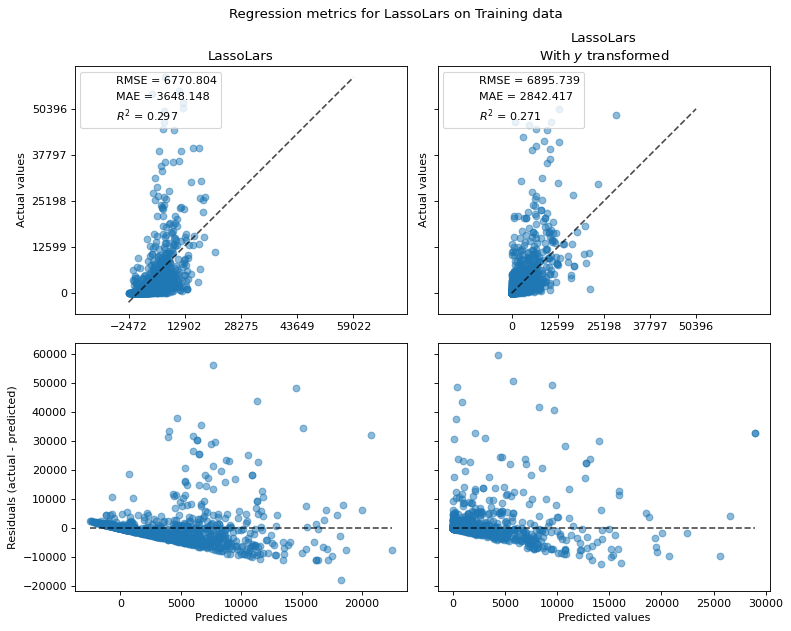

/tmp/ipykernel_13655/3549542784.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


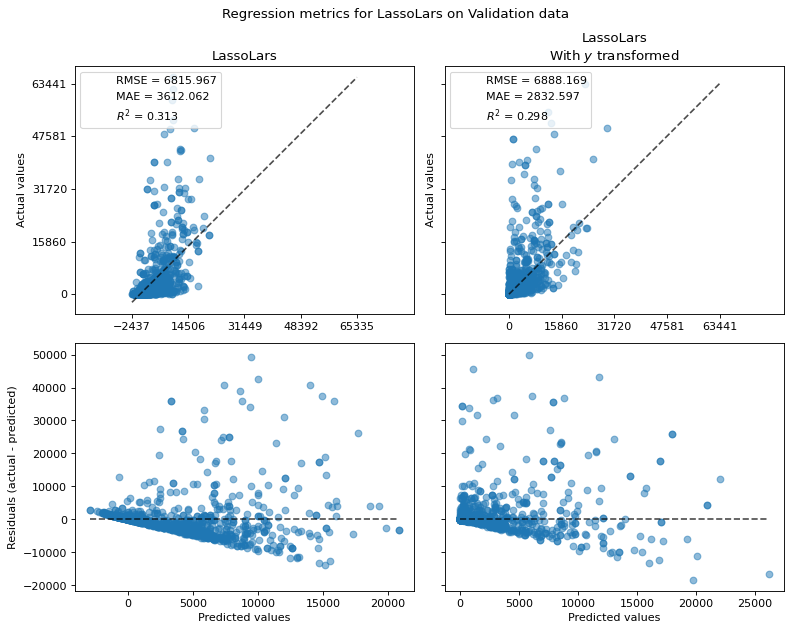




+----------------------------------------------------------------------+
|                          Regression metrics                          |
+------------------+----------+----------+----------+----------+-------+
| Split            |   RMSE   |   MAE    |  MedSE   |  MedAE   |  R^2  |
+------------------+----------+----------+----------+----------+-------+
| Training data    | 6770.804 | 3648.148 | 1919.325 | 1919.325 | 0.297 |
|  (y-transformed) | 6895.739 | 2842.417 |  645.27  | 645.269  | 0.271 |
| Validation data  | 6815.967 | 3612.062 | 1854.17  | 1854.17  | 0.313 |
|  (y-transformed) | 6888.169 | 2832.597 | 599.734  | 599.733  | 0.298 |
+------------------+----------+----------+----------+----------+-------+


In [25]:
from sklearn.metrics import PredictionErrorDisplay

regressor_name = best_estimator.named_steps["regression"].__class__.__name__

datasets = {
    "Training data": [X_train_reg, y_train_reg],
    "Validation data": [X_test_reg, y_test_reg],
}

rows = []  # For a PrettyTable
for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = best_estimator.predict(X_i)
    y_pred_transformed = best_estimator_y_transformed.predict(X_i)

    # Compute the regression metrics
    rmse, mae, medse, medae, r2 = my_metrics.compute_scores(y_i, y_pred)
    rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed = (
        my_metrics.compute_scores(y_i, y_pred_transformed)
    )

    # Round them to 3 decimal places
    rmse, mae, medse, medae, r2 = helpers.round_values(rmse, mae, medse, medae, r2)
    rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed = (
        helpers.round_values(
            rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed
        )
    )

    f, (ax0, ax1) = plt.subplots(2, 2, sharey="row", figsize=(10, 8), constrained_layout=True)

    # plot the actual vs predicted values
    PredictionErrorDisplay.from_predictions(
        y_i,
        y_pred,
        kind="actual_vs_predicted",
        ax=ax0[0],
        scatter_kwargs={"alpha": 0.5},
    )
    PredictionErrorDisplay.from_predictions(
        y_i,
        y_pred_transformed,
        kind="actual_vs_predicted",
        ax=ax0[1],
        scatter_kwargs={"alpha": 0.5},
    )

    # Add the score in the legend of each axis
    for ax, scores in zip(
        [ax0[0], ax0[1]], [[rmse, mae, r2], [rmse_transformed, mae_transformed, r2_transformed]]
    ):
        for name, score in zip(["RMSE", "MAE", "$R^2$"], scores):
            ax.plot([], [], " ", label=f"{name} = {score}")
        ax.legend(loc="upper left")

    ax0[0].set_title(f"{regressor_name}")
    ax0[1].set_title(f"{regressor_name}\nWith $y$ transformed")
    ax0[0].set_xlabel("")
    ax0[1].set_xlabel("")

    # plot the residuals vs the predicted values
    PredictionErrorDisplay.from_predictions(
        y_i,
        y_pred,
        kind="residual_vs_predicted",
        ax=ax1[0],
        scatter_kwargs={"alpha": 0.5},
    )
    PredictionErrorDisplay.from_predictions(
        y_i,
        y_pred_transformed,
        kind="residual_vs_predicted",
        ax=ax1[1],
        scatter_kwargs={"alpha": 0.5},
    )
    ax1[1].set_ylabel("")

    plt.suptitle(f"Regression metrics for {regressor_name} on {split_name.capitalize()}")
    plt.tight_layout()
    plt.show()

    print("\n\n")

    rows.append([split_name, rmse, mae, medse, medae, r2])
    rows.append(
        [
            " (y-transformed)",
            rmse_transformed,
            mae_transformed,
            medse_transformed,
            medae_transformed,
            r2_transformed,
        ]
    )

print(
    helpers.make_pretty_table(
        rows,
        title="Regression metrics",
        field_names=["Split", "RMSE", "MAE", "MedSE", "MedAE", "R^2"],
        alignments=["l"],
    )
)

### Export test set predictions for regression task

At this point, we can use our model to predict the medical expenses from the test sets. The following cell shows an example on how to do this.

You must save your predictions (`y_hat`) to a file and name the file in the following format:

`<TEAM_ID>__<SPLIT>__reg_pred.npy`

Make sure that:

`<TEAM_ID>` is your team id as given in CMS.

`<SPLIT>` is "test_public" during the semester and "test_private" for the final submission. We will write an announcement to CMS once the test_private dataset is available to download.

In [26]:
# Run this to save a file with your predictions on the test set to be submitted
# Specify the dataset split
split = "test_public"  # Replace by 'test_private' for FINAL submission

# Load the test data
df_test = pd.read_csv(f"data/{split}.csv")

# Make sure that we keep only the categorical cols that exist here
categorical_cols = helpers.remove_non_existent_columns(categorical_cols, df_test.columns)

# Handle the categorical columns in the test set
df_test = helpers.encode_categorical_cols(
    df_test, categorical_cols, categorical_encoder, return_only_encoded=False
)

# Drop the columns that were dropped during preprocessing
df_test = helpers.drop_existing_columns(df_test, low_variance_cols)
df_test = helpers.drop_existing_columns(df_test, correlated_cols)

# Use the best estimator to make predictions
y_hat = best_estimator_y_transformed.predict(df_test)

# Save the results with the format <TEAM_ID>__<SPLIT>__reg_pred.npy
folder = "./results"
np.save(
    os.path.join(folder, f"{team_id}__{split}__reg_pred.npy"), y_hat
)  # Note the double underscores '__' in the filename

/home/camilo/Repositorios/venvs/venv_rapids_24.06/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [34, 60, 76] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Linear classification

In this part, we will train a simple linear classification model to predict our target `UTILIZATION`.


In [27]:
k_classification = 20  # Number of top features to select for classification
select_k_best_classification = SelectKBest(score_func=chi2, k=k_classification)
X_classification_selected = select_k_best_classification.fit_transform(
    X_processed, y_classification
)
selected_features_classification = select_k_best_classification.get_support(indices=True)

NameError: name 'X_processed' is not defined

We will first change our targets (classes: LOW, HIGH) to numeric targets. Then, we solve a logistic regression problem by minimizing the binary cross-entropy function

$$
J(\theta) = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i \log(p_{\theta}(\hat{y}=1 | \mathbf{x}_i)) + (1 - y_i) \log(p_{\theta}(\hat{y}=0 | \mathbf{x}_i)) \right)
$$

where $y_i \in \{0, 1\}$ and $p_{\theta}(\hat{y}=k | \mathbf{x}_i)$ is the probability assigned by our model to class $k$ having observed features $\mathbf{x}_i$.

0 refers to HIGH, and 1 refers to LOW

### Process the data

In [ ]:
df_train = pd.read_csv(f"data/train.csv")

y = df_train["UTILIZATION"]

df_train.drop(columns=["UTILIZATION", "TOT_MED_EXP"])

le = preprocessing.LabelEncoder()
df_test["RACE"] = le.fit_transform(df_test["RACE"])

y = le.fit_transform(y)  # maps HIGH to 0 and LOW to 1

print(f"Original classes {le.classes_}")
print(f"Corresponding numeric classes {le.transform(le.classes_)}")


print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}", f", unique entries in y: {np.unique(y)}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# These hyperparameters are just placeholders, choosen without much care. For a good LogisticRegression baseline, play with them a bit.
clf = linear_model.LogisticRegression(
    penalty=None,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,  # None, balanced
    random_state=None,
    solver="lbfgs",
    max_iter=1500,
    multi_class="auto",
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)

### Fit the model by using training data

In [ ]:
clf = clf.fit(X_train, y_train)

Now evaluate your model. Check the appendix for details on micro, macro and weighted averaging

In [ ]:
datasets = {"training data": [X_train, y_train], "validation data": [X_val, y_val]}

for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f"\nSplit: {split_name}")

    print(skm.classification_report(y_i, y_pred))

At this point, we can use our model to predict healthcare utilization on the test set.

We again need to follow a specific namim format when saving the predictions. Similarly to before, the name of the file should be `<TEAM_ID>__<SPLIT>__clf_pred.npy`.



In [ ]:
# Run this to save a file with your predictions on the test set to be submitted

split = "test_public"  # replace by 'test_private' for FINAL submission

df_test = pd.read_csv(f"data/{split}.csv")

# Process data
df_test["RACE"] = LabelEncoder().fit_transform(df_test["RACE"])

y_hat = clf.predict(df_test)

# Save the results with the format <TEAM_ID>__<SPLIT>__clf_pred.npy

folder = "./"
np.save(os.path.join(folder, f"{team_id}__{split}__clf_pred.npy"), y_hat)

# Submission to CMS

Put your .npy files for both regression and classification tasks in the same zip file. Please name the file as `<TEAM_ID>.zip` (e.g. `123.zip`) and upload it to CMS system. It is essential that the files inside the .zip are named as follow:

`<TEAM_ID>__<SPLIT>__reg_pred.npy` \
`<TEAM_ID>__<SPLIT>__clf_pred.npy`

Above, `<SPLIT>` should correspond to `test_public` for the leaderboard and `test_private` for the final submission.
As long as the `test_private.csv` data file is not released yet, the zip will contain only two files.


### Appendix: Reminders about macro and micro averaging:

When evaluating a classification model using `skm.classification_report(y_i, y_pred)` as done above, we get a macro and a weighted average.

In the context of computing F1-score, "macro" and "micro" averaging are two commonly used techniques to aggregate the per-class F1-scores.

**Micro-average**: Compute the F1-score globally by counting the total true positives, false negatives, and false positives over all classes, and then calculating precision, recall, and F1-score using these aggregated values.

**Macro-average**: Calculate the F1-score for each class separately, and then take the average of these per-class F1-scores.

The main difference between these two techniques is the way they treat class imbalance. Micro-average treats all classes equally, regardless of their size, while macro-average treats each class equally, regardless of the number of samples in that class.

Micro-average is often used when we care about overall performance across all classes, and we want to give more weight to the performance on larger classes. In contrast, macro-average is often used when we want to evaluate the performance on each class separately and give equal weight to each class.


In addition to micro and macro averaging, there is another common technique for computing the F1-score called **weighted averaging**.

**Weighted averaging** is similar to macro averaging in that it computes the per-class F1-score and then takes the average of these scores. However, unlike macro averaging, weighted averaging takes into account the number of samples in each class when computing the average. Specifically, the weighted average is computed as follows:

- Compute the F1-score for each class separately.
- Compute the weight for each class as the number of samples in that class divided by the total number of samples.
- Compute the weighted average of the per-class F1-scores, where each per-class F1-score is weighted by the weight of that class.

The weighted average is commonly used when the dataset is imbalanced, meaning that some classes have many more samples than others. In such cases, using the simple average (macro-average) would give too much weight to the smaller classes, while using micro-average would give too much weight to the larger classes. The weighted average strikes a balance between these two approaches by giving more weight to the classes with more samples while still taking into account the performance of all classes.


When computing the F1 score for the leaderboard and the final challenge results, we will be using the macro averaging strategy.